In [1]:
import mxnet as mx
import mxnet.ndarray as nd
from mxnet import autograd
from mxnet import gluon

In [2]:
ctx = mx.cpu()

In [3]:
num_inputs = 2
num_outputs = 1
num_examples = 10000

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

X = nd.random_normal(shape=(num_examples, num_inputs))
noise = 0.01 * nd.random_normal(shape=(num_examples,))
y = real_fn(X) + noise

In [4]:
batch_size = 4
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset(X, y),
                                   batch_size=batch_size, shuffle=True)

In [5]:
net = gluon.nn.Sequential()

In [6]:
with net.name_scope():
    net.add(gluon.nn.Dense(1, in_units=2))

In [7]:
net.collect_params().initialize(mx.init.Normal(sigma=1.), ctx=ctx)

In [8]:
net.collect_params()

sequential0_ (
  Parameter sequential0_dense0_weight (shape=(1, 2), dtype=<class 'numpy.float32'>)
  Parameter sequential0_dense0_bias (shape=(1,), dtype=<class 'numpy.float32'>)
)

In [12]:
square_loss = gluon.loss.L2Loss()

In [13]:
square_loss

L2Loss(batch_axis=0, w=1.0)

In [15]:
trainer = gluon.Trainer(net.collect_params(), "sgd", {"learning_rate": 0.1})

In [16]:
epochs = 10
smoothing_constant = .01
moving_loss = 0
niter = 0
loss_seq = []

for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(batch_size)
        
        niter += 1
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss
        
        est_loss = moving_loss / (1 - (1-smoothing_constant) ** niter)
        loss_seq.append(est_loss)
    
    print("Epoch %s. Moving avg of MSE: %s" % (e, est_loss))

Epoch 0. Moving avg of MSE: 5.6604407813e-05
Epoch 1. Moving avg of MSE: 5.35690625469e-05
Epoch 2. Moving avg of MSE: 5.19519227091e-05
Epoch 3. Moving avg of MSE: 5.14934736487e-05
Epoch 4. Moving avg of MSE: 4.93796175872e-05
Epoch 5. Moving avg of MSE: 5.22579128795e-05
Epoch 6. Moving avg of MSE: 5.0580826012e-05
Epoch 7. Moving avg of MSE: 5.43291456239e-05
Epoch 8. Moving avg of MSE: 5.06590241936e-05
Epoch 9. Moving avg of MSE: 5.32379807115e-05


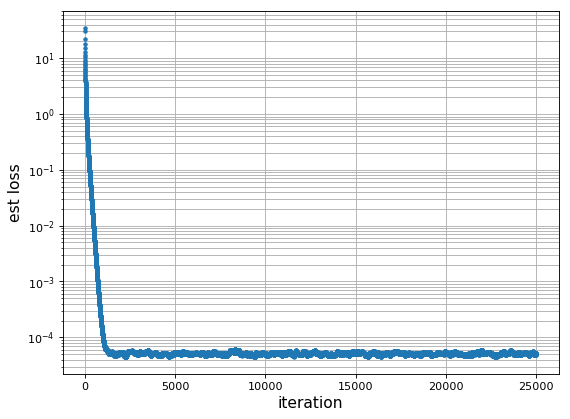

In [17]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(num=None,figsize=(8, 6),dpi=80, facecolor='w', edgecolor='k')
plt.semilogy(range(niter),loss_seq, '.')

# adding some additional bells and whistles to the plot
plt.grid(True,which="both")
plt.xlabel('iteration',fontsize=14)
plt.ylabel('est loss',fontsize=14)

In [18]:
params = net.collect_params() # this returns a ParameterDict

print('The type of "params" is a ',type(params))

# A ParameterDict is a dictionary of Parameter class objects
# therefore, here is how we can read off the parameters from it.

for param in params.values():
    print(param.name,param.data())

The type of "params" is a  <class 'mxnet.gluon.parameter.ParameterDict'>
sequential0_dense0_weight 
[[ 2.00066543 -3.40091658]]
<NDArray 1x2 @cpu(0)>
sequential0_dense0_bias 
[ 4.1999197]
<NDArray 1 @cpu(0)>
